In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'   #Download some custom weights

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False,  #Becaue you dont want their own dense layers (You have you own custom classes and so you need to define your own dense layer)
                                weights = None)   #Can use imagenet, etc. Specify None here so i can add custom weights

pre_trained_model.load_weights(local_weights_file)   #Load the custom weights in the model

for layer in pre_trained_model.layers: 
  layer.trainable = False   #Freeze the weights. Hence, during training the weights of the InceptionV3 CNN wont be updated (Only the dense layer weights will be updated)


last_layer = pre_trained_model.get_layer('mixed7')    #Get the mixed7 layer.
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output    #Get the output activations of this layer

--2020-06-19 07:39:27--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  82.9MB/s    in 1.0s    

2020-06-19 07:39:28 (82.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


You define the InceptionV3 Model just so that you can get the output activation of the mixed7 layer. (Which is a layer somewhat deep into the CNN and can hence detect more complex features: ears, eyes, etc) 

Subsequently, you use the output activation of this layer and feed it into your custom Dense layers for classification (Between horse and human)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

#As you are using an inceptionv3 model, no need to define the convolutional/pooling layers as they are already defined.
#Additionally, you no longer need to train the weights for the convolutional layers as the weights are already pretrained (as specified in the .h5 file you downloaded)
#Here, you only train the parameters in the Dense layer (Which classifies objects to your preference (human or horse))
#You dont want the dense layers of the InceptionV3 Model as the classses it is classifying is not the same as what you want (airplane, cats, etc.), hence you need to train your own classifier (Dense layer)
#Feed the output of the mixed7 layer to a densely connected layer (Flatten first)
x = layers.Flatten()(last_output)    #This means, take last_ouput as the input and perform layers.Flatten() on the input data
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x)  #Specify the input to be the input specified in the InceptionV3 Model (Get the correct shape and dtype)

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
print(pre_trained_model.input)

Tensor("input_1:0", shape=(None, 150, 150, 3), dtype=float32)


In [ ]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')  #Extract all the files to the directory '/tmp'.
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-06-19 07:39:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  88.1MB/s    in 0.7s    

2020-06-19 07:39:43 (88.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
100/100 [==============================] - 20s 203ms/step - loss: 0.3672 - accuracy: 0.8605 - val_loss: 0.1055 - val_accuracy: 0.9580
Epoch 2/20
100/100 [==============================] - 20s 196ms/step - loss: 0.2270 - accuracy: 0.9070 - val_loss: 0.1669 - val_accuracy: 0.9390
Epoch 3/20
 81/100 [=======================>......] - ETA: 3s - loss: 0.2075 - accuracy: 0.9204

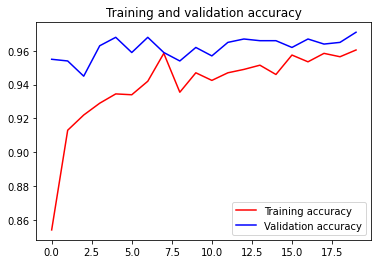

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()